In [1]:
# Load packages.
import pandas as pd
import numpy as np
import matplotlib



import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns


from datetime import datetime as dt
from datetime import timedelta


import yfinance as yf


import statsmodels.formula.api as sm
from statsmodels.iolib.summary2 import summary_col

In [2]:
def get_info_yfinance(tickers):
    try:
        detail = yf.Ticker(tickers)
        bookvalue_per_share = detail.info.get('bookValue')
    except:
        bookvalue_per_share = np.nan
    return bookvalue_per_share

In [3]:
xsvm_df = pd.read_csv("XSVM holdings.csv")
xsvm_df = xsvm_df[0:119]
xsvm_df = xsvm_df['Holding Ticker']
xsvm_df = pd.DataFrame(xsvm_df)
xsvm_df

,Holding Ticker
0,KELYA
1,VTLE
2,JXN
3,FDP
4,XRX
...,...
114,SMP
115,SVC
116,HCC
117,CEIX


In [4]:
temp_lst = []
for i in xsvm_df['Holding Ticker'].tolist():
    temp_lst.append(get_info_yfinance(str(i).strip()))

xsvm_out = xsvm_df.copy() 
xsvm_out['BVPS'] = temp_lst
xsvm_out = xsvm_out.dropna()
xsvm_out

,Holding Ticker,BVPS
0,KELYA,35.538
1,VTLE,82.378
2,JXN,122.514
3,FDP,39.814
4,XRX,20.610
...,...,...
113,OSUR,5.857
114,SMP,28.976
115,SVC,7.397
116,HCC,36.034


In [5]:
#picking the highest 10 book value stocks
top5 = xsvm_out.sort_values(by=['BVPS'], ascending=False).head(5)
top5

,Holding Ticker,BVPS
20,GPI,200.104
24,ABG,159.545
60,MTH,126.613
2,JXN,122.514
105,AMR,121.645


In [6]:
port_tickers = top5['Holding Ticker'].values
port_tickers = [i.strip() for i in port_tickers]
port_tickers

['GPI', 'ABG', 'MTH', 'JXN', 'AMR']

# Functions

In [40]:
def returns_df (date_time_start, date_time_end, tickers):
    start = date_time_start
    end = date_time_end
    
    df = yf.download(" ".join(tickers),start,end)["Adj Close"]
    df = df.pct_change()[1:] # turn the price dataframe into returns
    df = df.reset_index().rename(columns={"Date":"date"})    
    
    return df

#---------------------------------------------------------------------------------------------------
def excess_returns (data, col_name_rf, col_name_date):
    Rf = data[col_name_rf].values.copy()
    for column in data.columns:
        if column in [col_name_date, col_name_rf]:
            continue
        data[column] -= Rf
    return data

#---------------------------------------------------------------------------------------------------
def create_portfolio (data, ticker_lst, weights_lst, ):
    out = 0
    j = 0
    for i in range(len(ticker_lst)):
        out += weights_lst[j]*data[ticker_lst[i]]
    return out

#---------------------------------------------------------------------------------------------------
def cumulative_returns (data, tickers_and_portfolios, ):
    for col in tickers_and_portfolios:
        data[col+"_cum"] = (1 + data[col]).cumprod() - 1
    return data

#---------------------------------------------------------------------------------------------------


In [41]:
tmp1 = returns_df(dt(2024,1,1), dt(2024,3,10), ["^IRX"])
tmp1.head()

[*********************100%%**********************]  1 of 1 completed


,date,Adj Close
0,2024-01-03,0.004220
1,2024-01-04,-0.001337
2,2024-01-05,-0.001530
3,2024-01-08,0.000000
4,2024-01-09,0.001916


In [58]:
final_tickers = port_tickers.copy()
final_tickers.append('SPY')
final_tickers.insert(0, "^IRX")

tmp = returns_df(dt(2024,1,1), dt(2024,3,10), final_tickers)
tmp.rename(columns={"^IRX":"Mkt_RF"}, inplace=True) 

tmp['port_1'] = create_portfolio(tmp, port_tickers, [.1 for i in range(10)])

final_tickers.append('port_1')
tmp = excess_returns(tmp, 'Mkt_RF', 'date')

#---------------------------------------------------------------------------------------------------
final_tickers = port_tickers.copy()
final_tickers.append('SPY')
final_tickers.append('port_1')
tmp = cumulative_returns(tmp, final_tickers)
display(tmp.head())

[*********************100%%**********************]  7 of 7 completed


Ticker,date,ABG,AMR,GPI,JXN,MTH,SPY,Mkt_RF,port_1,GPI_cum,ABG_cum,MTH_cum,JXN_cum,AMR_cum,SPY_cum,port_1_cum
0,2024-01-03,-0.067808,-0.004396,-0.061761,-0.027619,-0.027235,-0.012387,0.004220,-0.020992,-0.061761,-0.067808,-0.027235,-0.027619,-0.004396,-0.012387,-0.020992
1,2024-01-04,-0.006666,0.061364,-0.010387,-0.000693,-0.001780,-0.001884,-0.001337,0.004852,-0.071506,-0.074022,-0.028966,-0.028293,0.056698,-0.014248,-0.016242
2,2024-01-05,-0.005523,0.017180,-0.003151,0.006413,0.011151,0.002900,-0.001530,0.003372,-0.074433,-0.079136,-0.018138,-0.022061,0.074853,-0.011389,-0.012924
3,2024-01-08,0.015617,-0.004356,0.004173,0.019437,0.012983,0.014276,0.000000,0.004786,-0.070570,-0.064755,-0.005391,-0.003053,0.070171,0.002724,-0.008201
4,2024-01-09,-0.000479,0.042462,-0.005297,-0.017805,-0.003797,-0.003433,0.001916,0.000551,-0.075493,-0.065203,-0.009167,-0.020803,0.115613,-0.000718,-0.007654


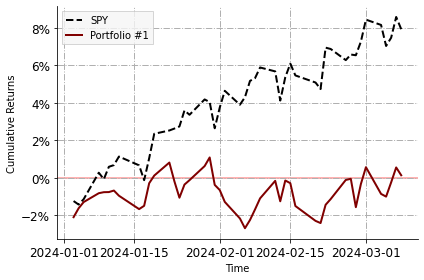

In [59]:
fig, ax=plt.subplots()

ax.plot(tmp.date.values, tmp.SPY_cum.values*100, color="black",ls="--", zorder=3,lw=2,label="SPY")
ax.plot(tmp.date.values, tmp.port_1_cum.values*100, color="maroon",ls="-", zorder=3,lw=2,label="Portfolio #1")
ax.axhline(0, color="red",zorder=1,alpha=0.4)
ax.grid(lw=1, ls="-.")

# Legend
legend = ax.legend(frameon=True,fancybox=False,loc="upper left",handlelength=1.6,facecolor="whitesmoke")

# Set size of xticks and yticks to 12
ax.tick_params(axis = "both", labelsize = 12)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
# Label x and y axes
ax.set_xlabel("Time")
ax.set_ylabel("Cumulative Returns")
sns.despine()
plt.tight_layout()